#library

In [1]:
import os
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
# from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations

In [2]:
from google.colab.patches import cv2_imshow
import imutils
import cv2
from skimage.feature import local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [3]:
def shape_detector(image):
  # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]
  cnts,_ = cv2.findContours(thresh, 1, 1)
  cnt = cnts[0]
  for c in cnts:
    area = cv2.contourArea(c)
    if area > cv2.contourArea(cnt):
      cnt = c
  return cnt

#Part1.compatness

In [4]:
def compatness(image):
  shape = shape_detector(image)
  area = cv2.contourArea(shape)
  primeter = cv2.arcLength(shape, True)
  compactness_score = np.divide((4 * np.pi * area), (np.square(primeter)))
  return compactness_score

#Part2.eccenticity

In [5]:
def eccenticity(image):
  shape = shape_detector(image)
  (x,y),(MA, ma),angle = cv2.fitEllipse(shape)
  if MA > ma:
    MA, ma = ma, MA
  eccentricity_score = np.sqrt( 1 - np.square(MA / ma))
  return eccentricity_score

#Part3.solidity

In [6]:
def solidity(image):
  shape = shape_detector(image)
  area = cv2.contourArea(shape)
  convex_hull = cv2.convexHull(shape)
  convex_hull_area = cv2.contourArea(convex_hull)
  solidity_score = float(area) / convex_hull_area
  return solidity_score

#Part4.LBP

In [7]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	lbp = local_binary_pattern(image, numPoints, radius, method="uniform")
	(hist, _) = np.histogram(lbp.ravel(), density=True, bins=256, range=(0, 256))
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)
	return hist

#validate function

In [8]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path, 0)
  airplane_img = cv2.imread(image_airplane_path, 0)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

In [ ]:
validating_func('/content/1412936.jpg', '/content/airplane153.jpg')

Result for ship image:
compatness is : 0.3900744545613469		eccenticity is : 0.8901555055181084		solidity is : 0.9471560558472225
Result for airplane image:
compatness is : 0.29043100592552473		eccenticity is : 0.8066844957099251		solidity is : 0.9043478216799644


#Part5.prepare dataset(just run this cell and not change)

In [9]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
To: /content/dataset.zip
100% 18.4M/18.4M [00:00<00:00, 81.4MB/s]
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/airplane/
  inflating: dataset/airplane/airplane1.jpg  
  inflating: dataset/airplane/airplane136.jpg  
  inflating: dataset/airplane/airplane14.jpg  
  inflating: dataset/airplane/airplane141.jpg  
  inflating: dataset/airplane/airplane153.jpg  
  inflating: dataset/airplane/airplane156.jpg  
  inflating: dataset/airplane/airplane157.jpg  
  inflating: dataset/airplane/airplane159.jpg  
  inflating: dataset/airplane/airplane169.jpg  
  inflating: dataset/airplane/airplane170.jpg  
  inflating: dataset/airplane/airplane182.jpg  
  inflating: dataset/airplane/air

In [10]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [12]:
def get_featureMatrix(data):
  feature_matrix = []
  for im in data:
    x = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    c = compatness(x)
    e = eccenticity(x)
    s = solidity(x)
    h = histogram_of_LBP(x, 8, 1, eps=1e-7)[0]
    feature_matrix.append([c, e, s, h])
  return feature_matrix


In [13]:
# model 1
x_train = np.array(x_train)
feature_matrix_train = np.array(get_featureMatrix(x_train))

#determine classifier and train
y_train = np.array(y_train)
svm = LinearSVC()
svm.fit(feature_matrix_train, y_train)

LinearSVC()

#Part7

In [14]:
#test on test dataset
x_test = np.array(x_test)
y_test = np.array(y_test)
feature_matrix_test = np.array(get_featureMatrix(x_test))
predicted_labels = svm.predict(feature_matrix_test)
print("accuracy: ",accuracy_score(y_test, predicted_labels))

accuracy:  0.71875


#Part8

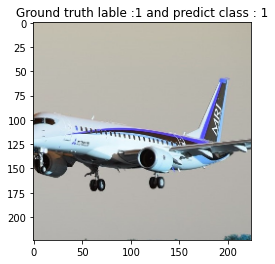

In [119]:
#test visualize
index = random.randint(0, len(x_test)-1)
# prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {predicted_labels[index]}")
plt.imshow(x_test[index])
plt.show()